In [1]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import pandas as pd

## Find long documents

In [2]:
import tiktoken

# Get encoding for GPT-4
encoding = tiktoken.encoding_for_model('gpt-4')

# Tokenization function
def tokenize_function(example):
    tokens = encoding.encode(example['text'])
    return {'input_ids': tokens, 'length': len(tokens)}


# Filtering function: keep only examples with more than 128 tokens
def filter_long_examples(example, limit=1024):
    return example['length'] > limit

# Count the number of tokens
def count_tokens(example):
    tokens = encoding.encode(example)
    token_counts = len(tokens)
    return token_counts

In [3]:

def filter_dataset(dataset_name, limit):
    # Load dataset
    dataset = load_dataset(dataset_name, "corpus")

    # Tokenize dataset
    tokenized_dataset = dataset.map(tokenize_function)

    # Apply filter
    filtered_dataset = tokenized_dataset.filter(lambda x: filter_long_examples(x, limit))

    return filtered_dataset


def filter_datasets(dataset_names, limit):
    filtered_datasets = {}
    for dataset_name in tqdm(dataset_names):
        filtered_dataset = filter_dataset(dataset_name, limit)

        # Check how many examples remain
        print(f"Filtered dataset size: {len(filtered_dataset['corpus'])}")

        filtered_datasets[dataset_name] = filtered_dataset

    return filtered_datasets

In [4]:
BeIR = {
    'Misc': ['BeIR/msmarco'], 
    'Fact checking': ['BeIR/fever', 'BeIR/climate-fever', 'BeIR/scifact'],
    'Citation-Prediction': ['BeIR/scidocs'],
    'Duplicate question retrieval': ['BeIR/quora'], # CQADupStack
    'Argument retrieval': ['BeIR/arguana'], # Touche-2020
    'News retrieval': [], # TREC-NEWS, Robust04
    'Question answering': ['BeIR/nq', 'BeIR/hotpotqa'], # FiQA-2018
    'Tweet retrieval': [], # Signal-1M
    'Bio-medical IR': ['BeIR/trec-covid', 'BeIR/nfcorpus'], # BioASQ
    'Entity retrieval': ['BeIR/dbpedia-entity'],
}
dataset_names = [dataset for datasets in BeIR.values() for dataset in datasets]

In [ ]:
filtered_datasets = filter_datasets(dataset_names, 512)

In [95]:
len(filtered_datasets)

12

In [96]:
all_docs = []

for dataset_name, dataset in filtered_datasets.items():
    if dataset_name == 'BeIR/fever':
        continue
    
    for sample in dataset['corpus']:
        sample['dataset'] = dataset_name
        all_docs.append(sample)

In [97]:
len(all_docs)

112270

In [73]:
import random

random.seed(42)
shuffled_docs = random.sample(all_docs, len(all_docs))
shuffled_docs = [{
    '_id': x['_id'], 'text': x['text'], 'length': x['length'], 'dataset': x['dataset']
    } for x in shuffled_docs]
shuffled_docs[:5]

[{'_id': 'Dave_Roller',
  'text': "David Euell Roller ( born October 28 , 1949 in Dayton , Tennessee ) is a former American football defensive lineman . While at Rhea Central High School in Dayton , David earned every honor including Coaches Magazine 's First Team All American and had 28 individual tackles in the first TSSAA All Star game in Nashville , TN , coached by Red Etter .   Roller played college football for the University of Kentucky Wildcats . David was voted national defensive lineman of the week against Kansas State his senior year . During his performance David Roller had seventeen unassisted tackles and six assists , leaving the top-10 ranked Kansas State offense with negative 93 yards rushing . David also had sixs sacks on Kansas State Quarterback Lynn Dickey during this game . Named SEC Player of the Week vs Missouri 1968 , TENNESSEE 1969 AND Kansas STATE 1970 . He was named to the first team All SEC in his junior and senior year and 2nd team his sophomore year and fir

In [74]:
# Assuming all_docs is your list of dictionaries
df = pd.DataFrame(shuffled_docs)

# Save to CSV
df.to_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/shuffled_long_docs.csv', index=False)

In [5]:
df = pd.read_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/shuffled_long_docs.csv')
df.head()

,_id,text,length,dataset
0,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever
1,Akhtar_Mohiuddin,"Akhtar Mohiuddin ( born in Chaman , Pakistan )...",4256,BeIR/climate-fever
2,Lou_Holtz_(actor),"Lou Holtz ( April 11 , 1893 -- September 22 , ...",1157,BeIR/climate-fever
3,Leiothrix_(plant),Leiothrix is a genus of plants in the Eriocaul...,1174,BeIR/climate-fever
4,Julian_McGauran,"Julian McGauran ( born 5 March 1957 ) , Austra...",1563,BeIR/climate-fever


In [76]:
df['segment_id'] = 0
df['segment_text'] = df['text']
df.to_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/long_docs.csv', index=False)

In [9]:
base_translated_df = pd.read_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/gpt-4o-mini-2024-07-18/long_documents/long_docs_evaluation.csv')
base_translated_df = base_translated_df[base_translated_df['translation'].notnull()]
unique_based_translated_ids = base_translated_df['_id'].unique().tolist()
base_translated_df.shape

(99, 29)

In [19]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def _split_document_by_segments(document: dict, max_tokens: int = 256):
        # Split document into sentences
        sentences = sent_tokenize(document['text'])

        # Split into segments based on max tokens
        segments = []
        current_segment = ""
        current_segment_tokens = 0

        for sentence in sentences:
            # Tokenize the sentence and count tokens
            sentence_tokens = count_tokens(sentence)
            
            # Check if adding this sentence would exceed max tokens
            if current_segment_tokens + sentence_tokens <= max_tokens:
                current_segment += " " + sentence
                current_segment_tokens += sentence_tokens
            else:
                # Add the current segment to the list
                segments.append(current_segment.strip())
                # Start a new segment with the current sentence
                current_segment = sentence
                current_segment_tokens = sentence_tokens

        # Add the last segment
        if current_segment:
            segments.append(current_segment.strip())

        # Print segments
        document_segments = []
        for idx, segment in enumerate(segments):
            document_segments.append({
                **document,
                '_id': str(document['_id']),
                'text': document['text'],
                'segment_id': idx,
                'segment_text': segment
            })
        return document_segments

[nltk_data] Downloading package punkt to /Users/asaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/asaf/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
all_segments = []
limit = 256
for idx, row in tqdm(df.iterrows()):
    document_segments = _split_document_by_segments(row.to_dict(), limit)
    all_segments.extend(document_segments)

print(f"Total documents splitted to {limit} tokens: {len(all_segments)}")
        
segmented_df = pd.DataFrame(all_segments)
segmented_df = segmented_df[segmented_df['_id'].isin(unique_based_translated_ids)]
segmented_df.to_csv(f'/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/long_docs_segmented_{limit}.csv', index=False)
print(f"Segmented documents saved to CSV: {segmented_df.shape}")
segmented_df.head()

0it [00:00, ?it/s]

Total documents splitted to 256 tokens: 54192
Segmented documents saved to CSV: (594, 6)


,_id,text,length,dataset,segment_id,segment_text
0,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,0,"David Euell Roller ( born October 28 , 1949 in..."
1,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,1,"In 2005 , Mr. Roller was inducted into the Uni..."
2,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,2,Roller played for the New York Giants ( 1971 -...
3,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,3,"While living in California , Mr. Roller appear..."
4,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,4,"David has 4 grandchildren : Lily , Tate , Anya..."


## Review evaluations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
results = []
data = [
    ("gpt-4o-mini-2024-07-18", 2048, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gpt-4o-mini-2024-07-18/long_docs_translated_evaluated.csv"),
    ("gpt-4o-mini-2024-07-18", 1024, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gpt-4o-mini-2024-07-18/long_docs_segmented_1024_translated_evaluated.csv"),
    ("gpt-4o-mini-2024-07-18", 512, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gpt-4o-mini-2024-07-18/long_docs_segmented_512_translated_evaluated.csv"),
    ("gpt-4o-mini-2024-07-18", 256, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gpt-4o-mini-2024-07-18/long_docs_segmented_256_translated_evaluated.csv"),

    ("gemini-2.0-flash-lite", 2048, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gemini-2.0-flash-lite/long_docs_translated_evaluated.csv"),
    ("gemini-2.0-flash-lite", 1024, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gemini-2.0-flash-lite/long_docs_segmented_1024_translated_evaluated.csv"),
    ("gemini-2.0-flash-lite", 512, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gemini-2.0-flash-lite/long_docs_segmented_512_translated_evaluated.csv"),
    ("gemini-2.0-flash-lite", 256, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/gemini-2.0-flash-lite/long_docs_segmented_256_translated_evaluated.csv"),

    ("google_gemma-2-27b-it", 2048, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/google_gemma-2-27b-it/long_docs_translated_evaluated.csv"),
    ("google_gemma-2-27b-it", 1024, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/google_gemma-2-27b-it/long_docs_segmented_1024_translated_evaluated.csv"),
    ("google_gemma-2-27b-it", 512, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/google_gemma-2-27b-it/long_docs_segmented_512_translated_evaluated.csv"),
    ("google_gemma-2-27b-it", 256, "/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/long_documents/google_gemma-2-27b-it/long_docs_segmented_256_translated_evaluated.csv"),
]
for model, limit, file_path in tqdm(data):
    evaluated_df = pd.read_csv(file_path)

    # Step 1: Group by '_id' and compute the average score per group
    grouped_scores = evaluated_df.groupby('_id')['score'].mean()

    # Step 2: Compute the overall average of the grouped scores
    overall_average = grouped_scores.mean()

    results.append({
        'model': model,
        'limit': limit,
        'score': overall_average/5,
        'file_path': file_path
    })


  0%|          | 0/12 [00:00<?, ?it/s]

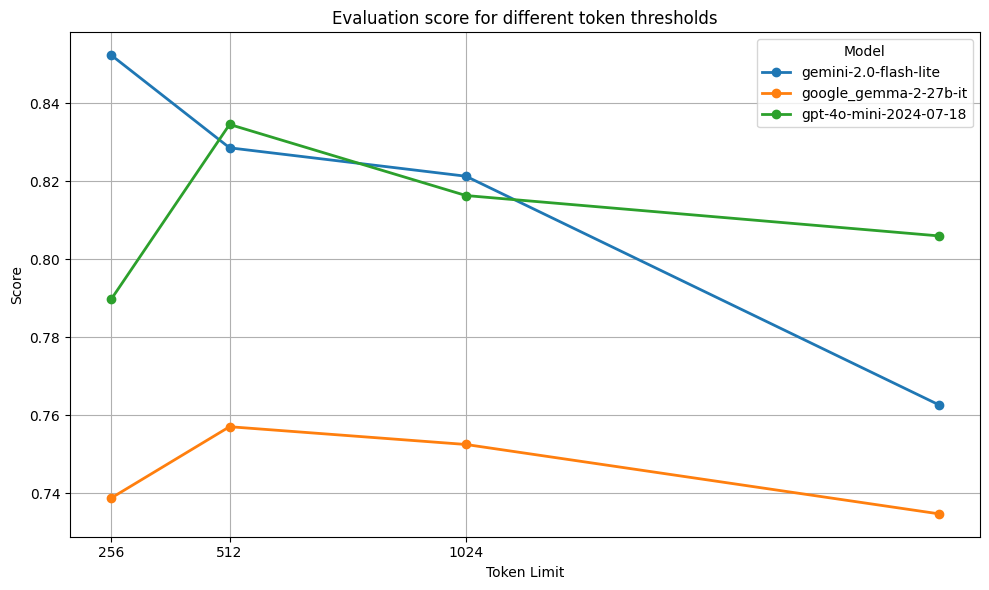

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined and has columns: 'limit', 'score', 'model'

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each model separately
for model_name, group in df.groupby("model"):
    plt.plot(group["limit"], group["score"], marker='o', linestyle='-', linewidth=2, label=model_name)

# Labels and title
plt.xlabel("Token Limit")
plt.xticks([1024, 512, 256])
plt.ylabel("Score")
# plt.ylim(0.6, 1)
plt.title("Evaluation score for different token thresholds")
plt.legend(title="Model")

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Merge with evaluation

In [88]:
file_name = 'long_docs.csv'
source_df = pd.read_csv(f'/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/{file_name}')
translation_df = pd.read_csv(f'/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/gpt-4o-mini-2024-07-18/long_documents/{file_name}')
selected_columns = ["_id", "segment_id", "translation", "translation_datetime","system_prompt","user_prompt","prompt_file_name", 'model_name', 'model_time']
print(len(translation_df[~translation_df['translation'].isna()]))
translation_df[~translation_df['translation'].isna()][selected_columns].head(30)



99


,_id,segment_id,translation,translation_datetime,system_prompt,user_prompt,prompt_file_name,model_name,model_time
0,Dave_Roller,0,דיוויד יואל רולר (נולד ב-28 באוקטובר 1949 בדיי...,2025-03-19 18:12:22.257697,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,37.893707
1,Akhtar_Mohiuddin,0,"אכטר מוחיודין (נולד בח'מן, פקיסטן), הוא המאמן ...",2025-03-19 18:14:34.163400,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,169.801842
2,Lou_Holtz_(actor),0,"לוא הולץ (11 באפריל 1893 - 22 בספטמבר 1980, בב...",2025-03-19 18:12:23.882741,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,39.521419
3,Leiothrix_(plant),0,Leiothrix הוא סוג של צמחים במשפחת ה-Eriocaulac...,2025-03-19 18:12:00.913979,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,16.552759
4,Julian_McGauran,0,"ג'וליאן מקגורן (נולד 5 במרץ 1957), פוליטיקאי א...",2025-03-19 18:12:43.085356,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,58.723813
5,Everything's_Coming_up_Roses,0,"""הכל מגיע עם ורדים"" היא שיר מתוך המוזיקל בברוד...",2025-03-19 18:12:44.809119,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,60.447877
6,Die_Tödliche_Doris,0,דַּיֵּי טוֹדְלִיכֶה דּוֹרִיס (דוריס הקטלנית; מ...,2025-03-19 18:12:35.638404,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,51.271717
7,Colonel_March_of_Scotland_Yard,0,הקולונל מארץ של סקוטלנד יארד היא סדרת טלוויזיה...,2025-03-19 18:12:17.553193,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,33.191921
8,Razi_High_School,0,ליקיי רזי (בפרסית: دبیرستان رازی) מתורגם לאנגל...,2025-03-19 18:12:36.698742,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,52.337422
9,Arcadia_(popular_culture),0,"בעקבות משמעותה המיתולוגית כטבע פראי, הרמוני ול...",2025-03-19 18:13:21.120159,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,80.197246


In [89]:
merged_df = source_df.merge(translation_df[selected_columns],
                            on=["_id", "segment_id"], 
                            how="left")
merged_df[:300].to_csv(f'/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/gpt-4o-mini-2024-07-18/long_documents/{file_name}', index=False)

merged_df.head()

,_id,text,length,dataset,segment_id,segment_text,translation,translation_datetime,system_prompt,user_prompt,prompt_file_name,model_name,model_time
0,Dave_Roller,"David Euell Roller ( born October 28 , 1949 in...",1033,BeIR/climate-fever,0,"David Euell Roller ( born October 28 , 1949 in...",דיוויד יואל רולר (נולד ב-28 באוקטובר 1949 בדיי...,2025-03-19 18:12:22.257697,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,37.893707
1,Akhtar_Mohiuddin,"Akhtar Mohiuddin ( born in Chaman , Pakistan )...",4256,BeIR/climate-fever,0,"Akhtar Mohiuddin ( born in Chaman , Pakistan )...","אכטר מוחיודין (נולד בח'מן, פקיסטן), הוא המאמן ...",2025-03-19 18:14:34.163400,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,169.801842
2,Lou_Holtz_(actor),"Lou Holtz ( April 11 , 1893 -- September 22 , ...",1157,BeIR/climate-fever,0,"Lou Holtz ( April 11 , 1893 -- September 22 , ...","לוא הולץ (11 באפריל 1893 - 22 בספטמבר 1980, בב...",2025-03-19 18:12:23.882741,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,39.521419
3,Leiothrix_(plant),Leiothrix is a genus of plants in the Eriocaul...,1174,BeIR/climate-fever,0,Leiothrix is a genus of plants in the Eriocaul...,Leiothrix הוא סוג של צמחים במשפחת ה-Eriocaulac...,2025-03-19 18:12:00.913979,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,16.552759
4,Julian_McGauran,"Julian McGauran ( born 5 March 1957 ) , Austra...",1563,BeIR/climate-fever,0,"Julian McGauran ( born 5 March 1957 ) , Austra...","ג'וליאן מקגורן (נולד 5 במרץ 1957), פוליטיקאי א...",2025-03-19 18:12:43.085356,You are a precise and concise translation assi...,Translate the following English text into Hebr...,prompts/translation/openai/translation_prompts...,gpt-4o-mini-2024-07-18,58.723813


In [16]:
base_translated_df = pd.read_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/gpt-4o-mini-2024-07-18/long_documents/long_docs_evaluation.csv')
base_translated_df = base_translated_df[base_translated_df['translation'].notnull()]
unique_based_translated_ids = base_translated_df['_id'].unique().tolist()
base_translated_df.shape

(99, 29)

In [18]:
segmented_evaluated_1024_df = pd.read_csv('/Users/asaf/Workspace/biu/hebrew_text_retrieval/outputs/translation/BeIR/gpt-4o-mini-2024-07-18/long_documents/long_docs_segmented_1024_evaluation.csv')
segmented_evaluated_1024_df = segmented_evaluated_1024_df[segmented_evaluated_1024_df['translation'].notnull() & segmented_evaluated_1024_df['_id'].isin(unique_based_translated_ids)]
segmented_evaluated_1024_df.shape

(4, 29)